In [1]:
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
def plot(name, ax=None, **kwargs):
    data = pd.read_csv(f'../data/{name}.csv', names=['duration', 'score'])

    if ax is None:
        fig, ax = plt.subplots() 
        data.plot.scatter('duration', 'score', ax=ax, alpha=0.25, c='gray')
    data.duration = pd.to_timedelta(data.duration, 'ms')
    rolling_scores = data.set_index('duration').sort_index().score.rolling('750ms', center=True).mean()
    
    rolling_scores = rolling_scores.to_frame().reset_index()
    rolling_scores.duration = rolling_scores.duration.dt.total_seconds() * 1000
    
    
    ax.plot(rolling_scores.duration, rolling_scores.score, **kwargs)
    #plt.figtext(0.5, 0.25, 'The model improves with\nmore search time, but\nquickly plateaus at\naround 2000 ms.', fontsize=10)
    
    plt.title('Model score given duration in ms')
    plt.ylim((0, 60))
    plt.xlim((0, 4000))
    
    ax

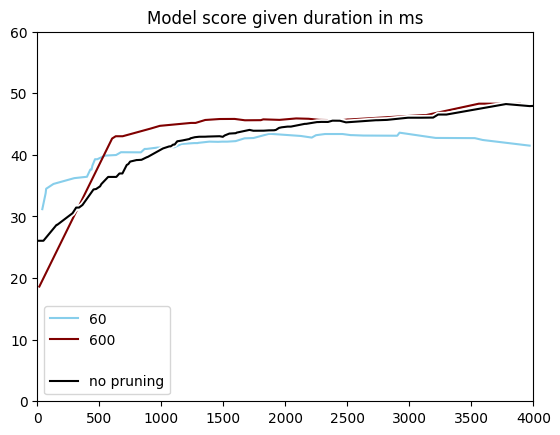

In [25]:
fig, ax = plt.subplots() 

plot('test', ax=ax, c='skyblue')
plot('prune-600-', ax=ax, c='maroon')
plot('no-prune', ax=ax, c='white', lw=4)
plot('no-prune', ax=ax, c='black')

plt.legend(['60', '600', '', 'no pruning'])

(0.0, 2000.0)

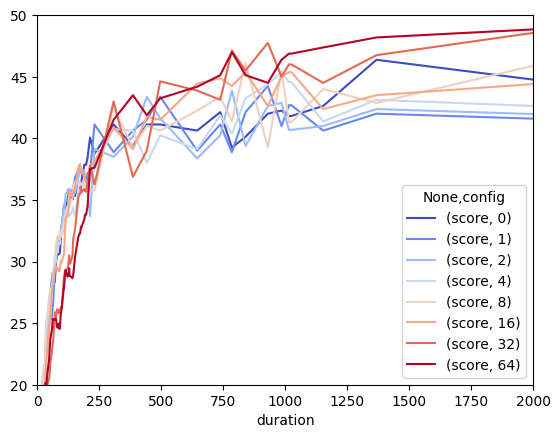

In [195]:
df = pd.read_csv('../data/heuristics.csv', names=['config', 'duration', 'score'])
df.config = df.config.str.replace('./config/heuristics-alpha-', '').str.replace('.json', '').astype(int)
df.duration = pd.to_timedelta(df.duration, 'ms')
#df = df.set_index(['config','duration'])
fig, ax = plt.subplots() 

processed = df.pivot_table(values='score', index=['config', 'duration'], aggfunc='mean') \
    .unstack('config') \
    .rolling('30ms', center=True) \
    .mean() \
    .interpolate()

processed.index = processed.reset_index().duration.dt.total_seconds() * 1000
processed.plot(cmap='coolwarm', ax=ax)


plt.ylim((20, 50))
plt.xlim((0, 2000))

In [864]:
pd.read_csv(f'../data/no-prune.csv', names=['duration', 'score'])

FileNotFoundError: [Errno 2] No such file or directory: '../data/no-prune.csv'

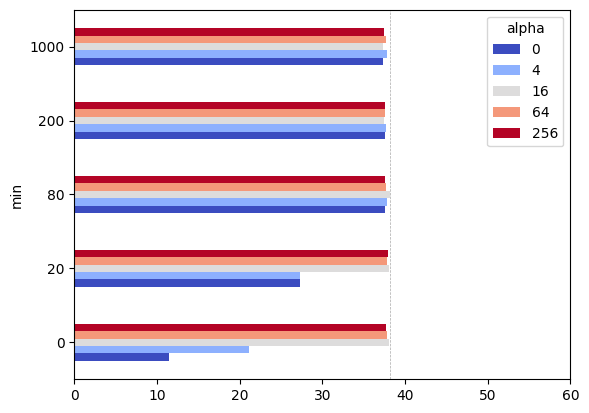

In [865]:
df = pd.read_csv('../data/heuristics-prune-matrix.csv', names=['config', 'duration', 'score'])
df[['min', 'alpha']] = df.config.str.replace('./config/heuristics-', '').str.replace('.json', '').str.split('-', expand=True).astype(int)
df.duration = pd.to_timedelta(df.duration, 'ms')
df = df.set_index(['min', 'alpha', 'duration'])

processed = df.pivot_table(values='score', index=['alpha'], columns=['min'], aggfunc='mean')
processed.T.plot.barh(cmap='coolwarm')
plt.xlim((0,60))
processed.round(2)

plt.axvline(
    processed.max().max(),
    lw=0.5,
    ls='--',
    c='darkgray'
)

plt.show()

(0.0, 2000.0)

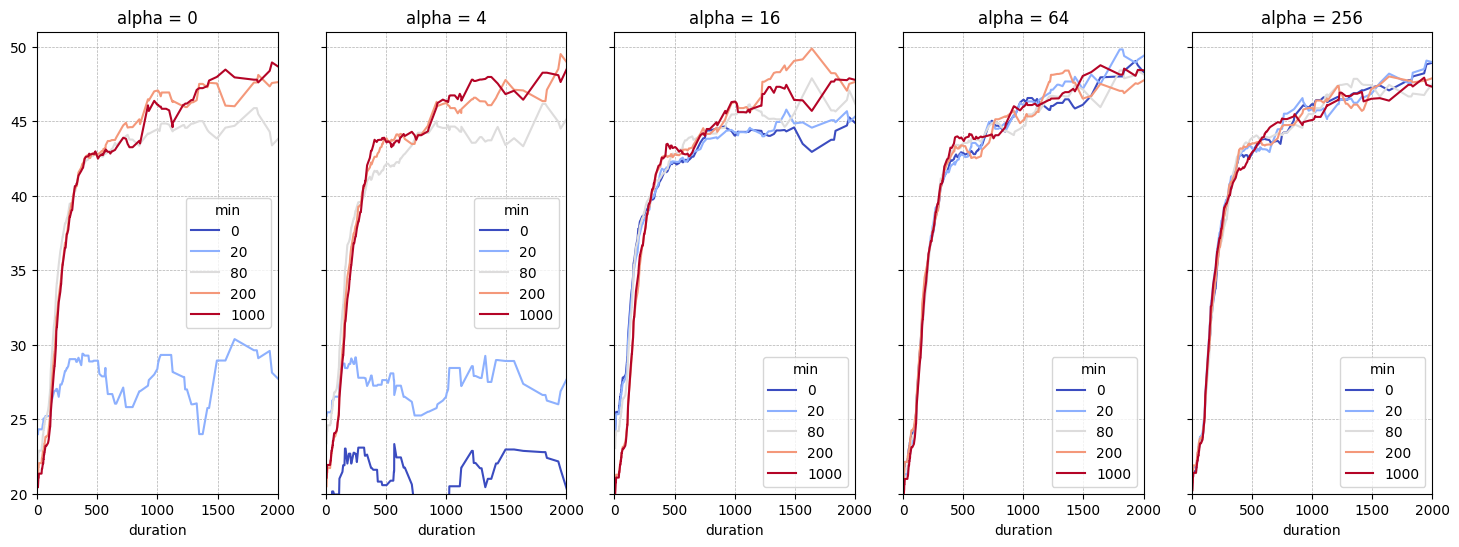

In [866]:
processed = df.pivot_table(values='score', index=['duration'], columns=['alpha', 'min'], aggfunc='mean')
rolling = processed.rolling('200ms', center=True).mean().interpolate()

rolling.index = rolling.index.to_frame().duration.dt.total_seconds() * 1000

fig, ax = plt.subplots(1, 5, figsize=(18,6), sharey=True, sharex=True)


#.plot(figsize=(12,12), color=cmap)
for i, alpha in enumerate(rolling.columns.levels[0]):    
    rolling[alpha].plot(cmap="coolwarm", ax=ax[i])
    ax[i].grid(linewidth=0.5, linestyle='--')
    ax[i].set_title(f'alpha = {alpha}')

plt.ylim((20, 51))
plt.xlim((0, 2000))

## Exploration values

In [867]:
df = pd.read_csv('../data/exploration-value.csv', names=['config', 'duration', 'score'])
df.config = df.config \
    .str.replace('./config/heuristics', '') \
    .str.replace('.json', '') \
    .str.replace('-exploration-', '') \
    .str.replace('-', '.')

df.duration = pd.to_timedelta(df.duration, 'ms')

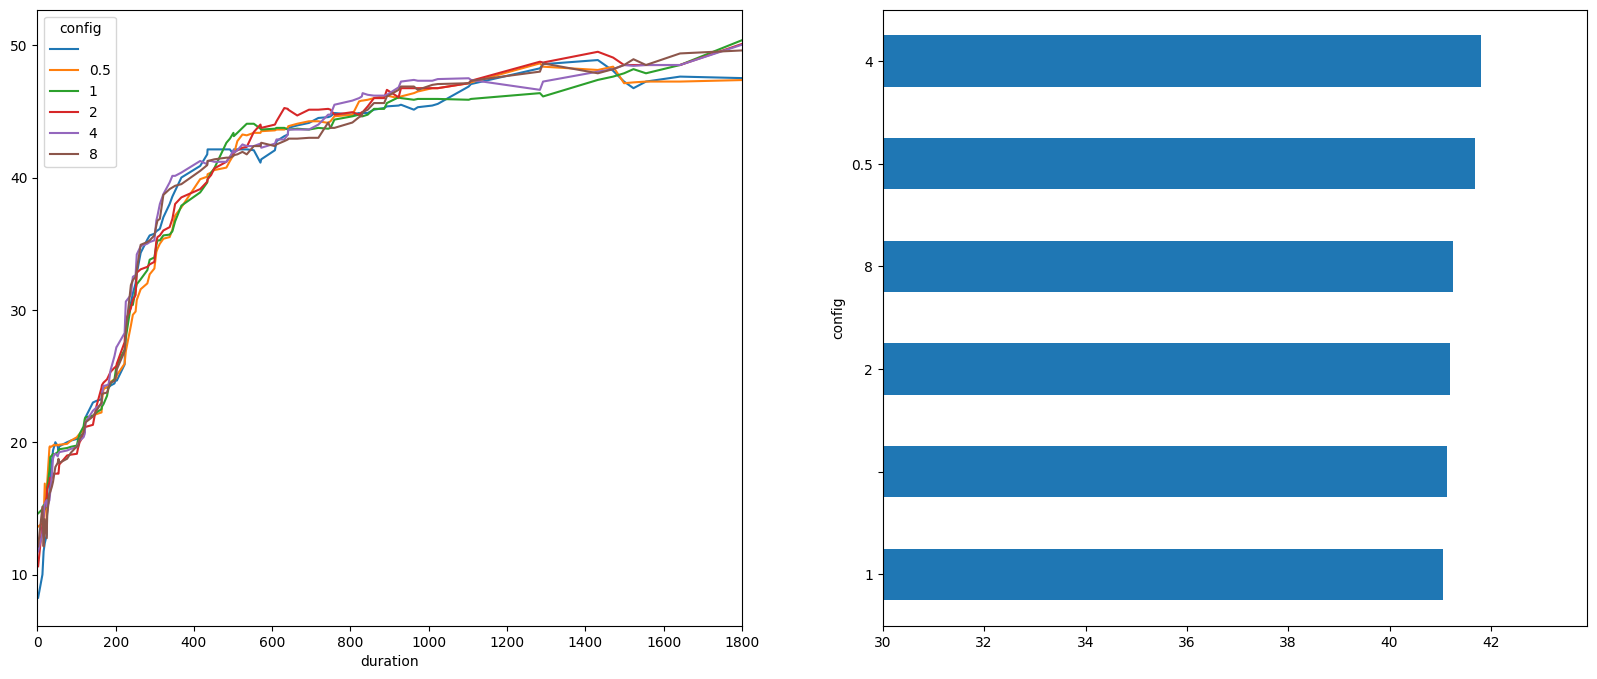

In [868]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
pivot = df.pivot_table(values='score', index=['duration'], columns=['config'], aggfunc='mean')
rolling = pivot.rolling('200ms').median()
rolling.index = rolling.index.to_frame().duration.dt.total_seconds() * 1000

pivot.dropna().median().sort_values().plot.barh(ax=ax[1])
ax[0].set_xlim((0, 1800))
ax[1].set_xlim((30, None))

rolling.interpolate().plot(ax=ax[0])
plt.show()

/Users/havegum/Documents/10-prosent/railroad-think/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


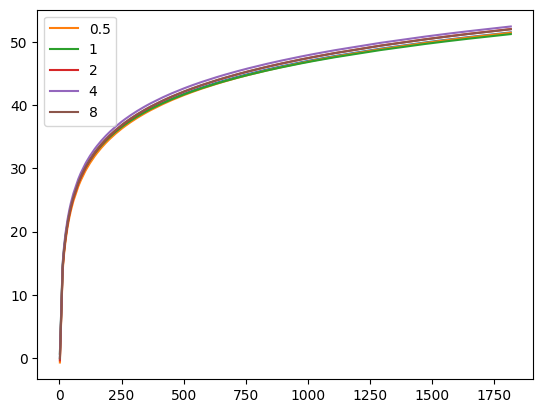

In [869]:
from scipy.optimize import curve_fit
import numpy as np
plt.figure()

def func(x, a, b, c):
  #return a * np.exp(-b * x) + c
  return a * np.log(b * x) + c
for c in ['', '0.5', '1', '2', '4', '8']:
    _ = df.sort_values('duration')
    y = _[_.config == c].score.values
    x = _[_.config == c].duration.dt.total_seconds() * 1000
    
    #x = np.linspace(1,5,50)   # changed boundary conditions to avoid division by 0
    #y = func(x, 2.5, 1.3, 0.5)
    # yn = y + 0.2*np.random.normal(size=len(x))
    
    popt, pcov = curve_fit(func, x, y)
    #plt.plot(x, y, 'ko', label="Original Noised Data", ms=1)
    plt.plot(x, func(x, *popt), label=c)

plt.legend()
plt.show()

In [875]:
df = pd.read_csv('../data/unexploration-value.csv', names=['config', 'duration', 'score'])
df.config = df.config \
    .str.replace('./config/heuristics', '') \
    .str.replace('.json', '') \
    .str.replace('-unexplored-', '') \
    .str.replace('-', '.')

df.duration = pd.to_timedelta(df.duration, 'ms')

<Axes: ylabel='config'>

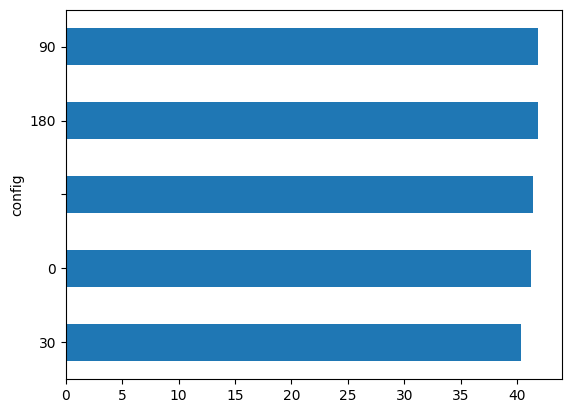

In [876]:
pivot = df.pivot_table(values='score', index=['duration'], columns=['config'], aggfunc='mean')
pivot.dropna().median().sort_values().plot.barh()

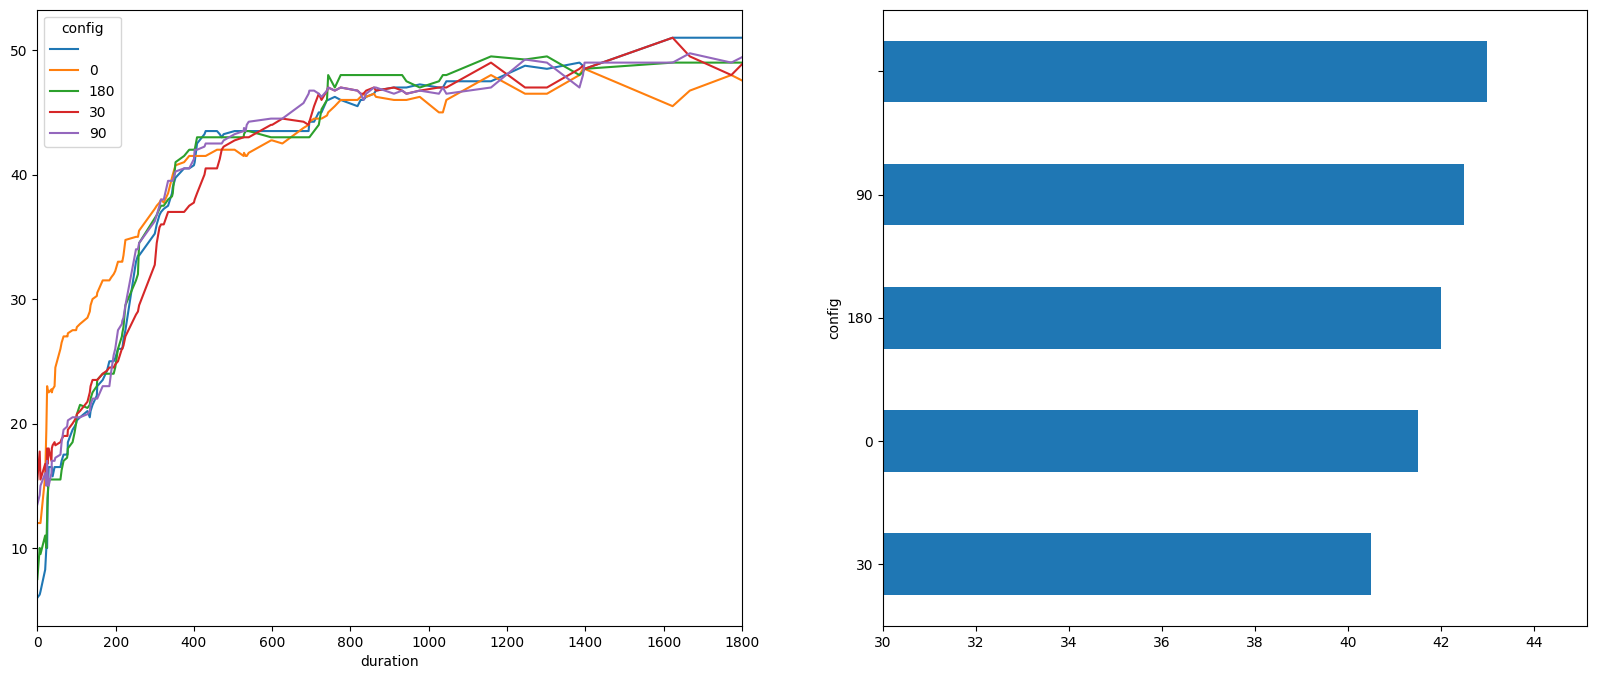

In [877]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
pivot = df.pivot_table(values='score', index=['duration'], columns=['config'], aggfunc='median')
rolling = pivot.rolling('200ms').median()
rolling.index = rolling.index.to_frame().duration.dt.total_seconds() * 1000

pivot.dropna().median().sort_values().plot.barh(ax=ax[1])
ax[0].set_xlim((0, 1800))
ax[1].set_xlim((30, None))

rolling.interpolate().plot(ax=ax[0])
plt.show()